# Denoising example with a 3d image (cube)

In this notebook we show how to apply Clear-Skies to 3d image denoising. This applies denoising to a real data set.

In [322]:
import sys
#put path of Clear-Skies folder repository
sys.path.insert(0,'../../Clear-Skies')
#put path of Optimus Primal folder repository
sys.path.insert(0,'../../Optimus-Primal')
import numpy as np
from clearskies import solver
from clearskies import map_uncertainty
from astropy.io import fits
from astropy.utils.data import download_file
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from spectral_cube import SpectralCube

import matplotlib.axes as maxes

In [324]:
def colorbar(mappable, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=maxes.Axes)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(ax)
    return cbar

In [2]:
def open_fits(image_file):
    hdu_list = fits.open(image_file)
    return hdu_list[0].data
def open_header(image_file):
    hdu_list = fits.open(image_file)
    return hdu_list[0].header

Here we load the data cube

In [400]:
hi_datafile = download_file(
    'http://data.astropy.org/tutorials/FITS-cubes/reduced_TAN_C14.fits', #about 38 mb in size
    cache=True, show_progress=True)
hi_data = fits.open(hi_datafile)  # Open the FITS file for reading
x = hi_data[0].data
header = hi_data[0].header
cube = SpectralCube.read(hi_data)  # Initiate a SpectralCube
hi_data.close()  # Close the FITS file - we already read it in and don't need it anymore!

Here we choose the noise level and region of the image to denoise

(450, 150, 150)
0.035


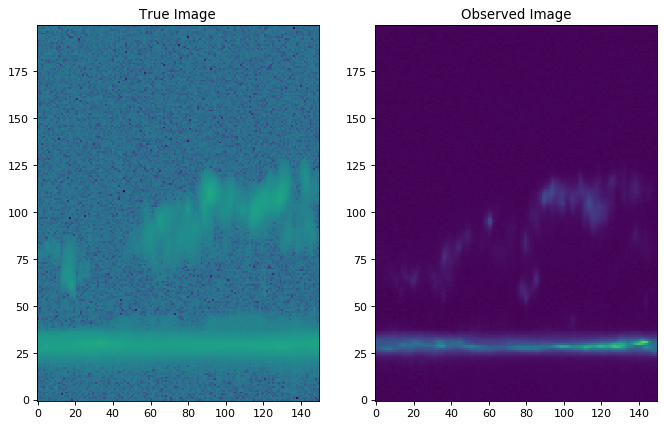

In [401]:
print(x.shape)
x_true = x[195:395,:,:]
x_true[np.isnan(x[195:395,:,:])] = 0
sigma = 0.035 #np.std(x[50:200, :20, :200])

W = np.ones(x_true.shape)

y = x_true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), dpi=80, sharey=False, sharex=True)
ax[0].imshow(np.log(np.abs(x_true[:,10,:])), vmax=np.max(x_true) * 0.1,origin='lower')
ax[0].set_title("True Image")
ax[1].imshow(y[:, 0,:], vmax=np.max(x_true) * 0.1,origin='lower')
ax[1].set_title("Observed Image")
print(sigma)

Below we choose the dictionary that we expect to represent our signal. Dirac is good for point sources, wavelets are good for extended and smooth signals on different scales. More levels is good for extended sources because the largest level probes the largest scales. We normally require that image width > $2^{\rm levels - 1}$. Typically a redundent dictionary works well for many complex images.

In [52]:
wav = ["dirac", "db1", "db2", "db3", "db4","db5", "db6", "db7", "db8"]
#wav = ["db8"]
#wav = ["dirac"]
levels = 2
axes = None

Here we choose the options for our algorithm, how iterations, real + positivity constraints, tollerance for convergence.

In [59]:
options = {'tol': 1e-5, 'iter': 5000, 'update_iter': 1, 'record_iters': False, 'positivity': False, 'real': False}
beta = 1e-2

Next we run the solver for our solution image $\mathbf{z}$ to the minimum of
$$ \|\mathbf{\Psi} \mathbf{x} \|_{\ell_1}\quad {\rm such\, that}\quad \|\mathbf{W} \mathbf{x} - \mathbf{W}\mathbf{y} \|_{\ell_2} \leq \epsilon $$
where $\epsilon = \sigma_{\rm noise}\sqrt{N + 2\sqrt{2N}}$. $\mathbf{\Psi}$ is the wavelet dictionary transform and $\mathbf{W}$ is the noise weights. $\|\mathbf{\alpha} \|_{\ell_1} = \sum_k |\alpha_k|$ and $\|\mathbf{\alpha} \|_{\ell_2} = \sqrt{\sum_k |\alpha_k|^2}$.

The basic idea is that $\mathbf{z}$  will not overfit to the signal because it can be efficiently represented with the dictionary.

In [60]:
z, diag = solver.solver(solver.algorithm.l1_constrained, y, sigma, W, wav, axes, levels, beta, options)

2020-05-20 15:31:57,400 - Clear Skies - INFO - Using wavelets ['dirac', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8'] with 2 levels
2020-05-20 15:31:57,402 - Clear Skies - INFO - Using an estimated noise level of 0.035 (weighted image units, i.e. Jy/Beam)
2020-05-20 15:32:00,610 - Clear Skies - INFO - Denosing using constrained l1 regularization
2020-05-20 15:32:07,535 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020-05-20 15:32:16,199 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.333333
2020-05-20 15:32:29,936 - Optimus Primal - INFO - [Primal Dual] 1 out of 5000 iterations, tol = 0.114772
2020-05-20 15:32:43,226 - Optimus Primal - INFO - [Primal Dual] 2 out of 5000 iterations, tol = 0.026327
2020-05-20 15:32:56,394 - Optimus Primal - INFO - [Primal Dual] 3 out of 5000 iterations, tol = 0.115241
2020-05-20 15:33:09,776 - Optimus Primal - INFO - [Primal Dual] 4 out of 5000 iterations, tol = 0.166073
2020-05-20 15:33:23,394 - Opti

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  150                                                  NAXIS2  =                  150                                                  NAXIS3  =                  450                                                  OBJECT  = 'HI4PI   '           / The HI 4-PI Survey                             TELESCOP= 'Effelsberg 100m RT; ATNF Parkes 64-m' / Telescope names              ORIGIN  = 'AIfA/MPIfR Bonn; ATNF Sydney' / Organisations or Institutions        REFERENC= 'HI4PI Collaboration 2016' / A&A                                      RESTFRQ =        1420405751.77                                                  RESTWAV =       0.211061140541                                                  WCSAXES =                    3          

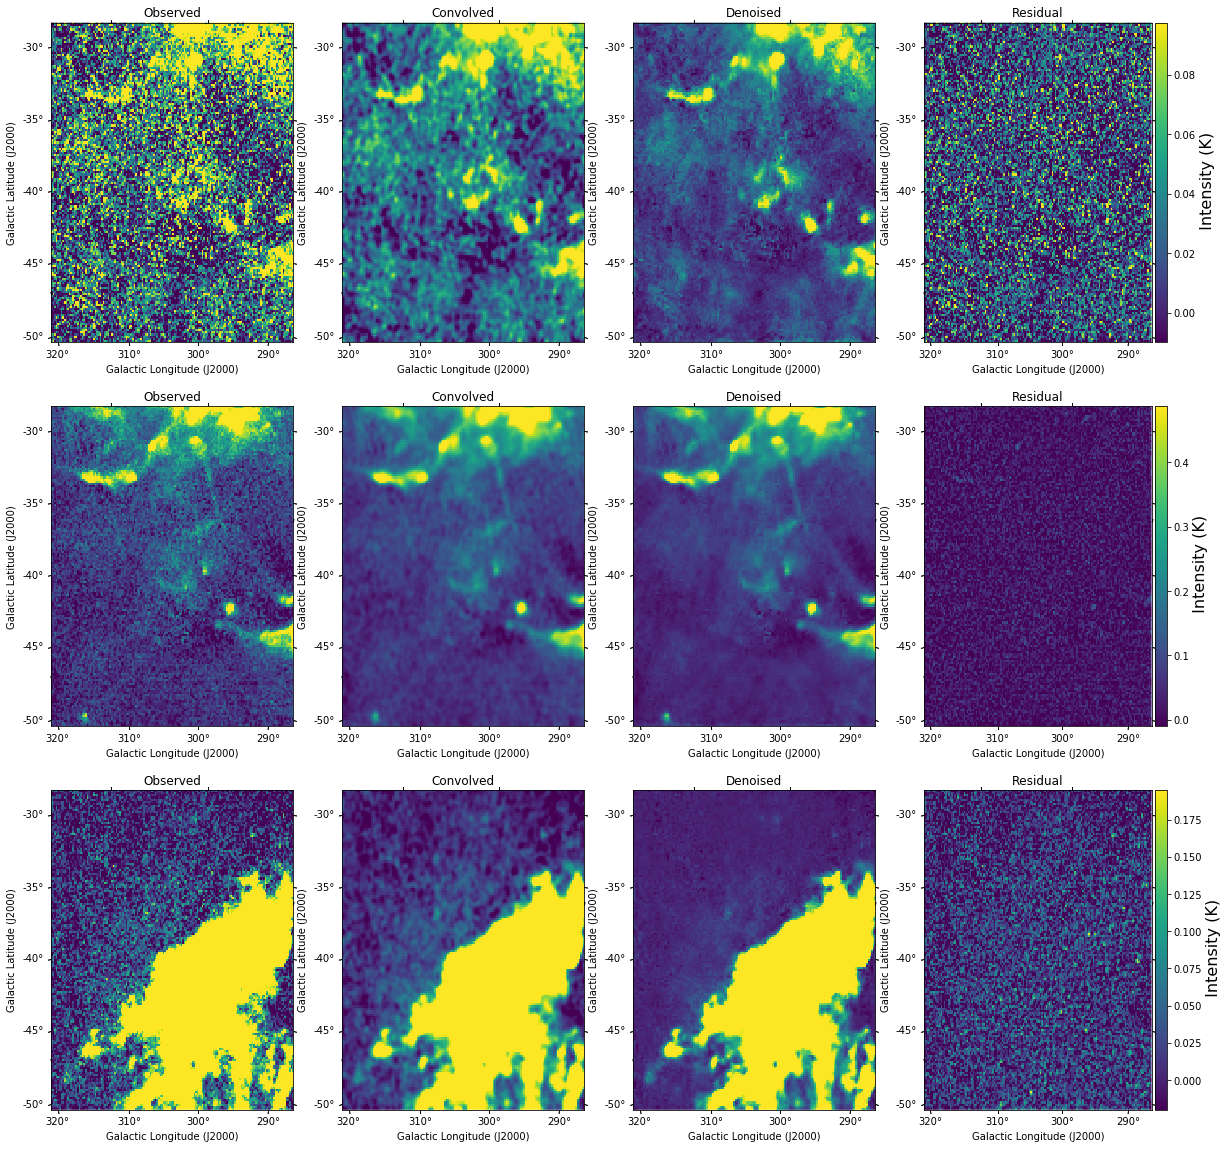

In [402]:
from scipy.ndimage import gaussian_filter
from astropy.wcs import WCS

hi4pi_wcs = WCS(header) 
fig = plt.figure(figsize=(20, 20))



x_blurr = gaussian_filter(x_true,sigma = (0, 1, 1))
max_val = np.max([np.max(x_blurr[:, :, :]), np.std(x_blurr[:, :, :])]) * 0.001
min_val = -1e-2
for channel in [10]:
    ax = fig.add_subplot(3, 4, 1, projection=hi4pi_wcs[195 + channel])
    ax.imshow(x_true[channel,:,:], vmax=max_val,vmin=min_val,origin='lower',aspect="auto")
    ax.set_xlabel('Galactic Longitude (J2000)')
    ax.set_ylabel('Galactic Latitude (J2000)')
    ax.set_title("Observed")
    ax = fig.add_subplot(3, 4, 2, projection=hi4pi_wcs[195 + channel])
    ax.imshow(x_blurr[channel,:,:], vmax=max_val,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Convolved")
    ax.set_xlabel('Galactic Longitude (J2000)')
    ax.set_ylabel('Galactic Latitude (J2000)')
    ax = fig.add_subplot(3, 4, 3, projection=hi4pi_wcs[195 + channel])
    ax.imshow(np.real(z[channel,:, :]), vmax=max_val,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Denoised")
    ax.set_xlabel('Galactic Longitude (J2000)')
    ax.set_ylabel('Galactic Latitude (J2000)')
    ax = fig.add_subplot(3, 4, 4, projection=hi4pi_wcs[195 + channel])
    ax.set_title("Residual")
    ax.set_xlabel('Galactic Longitude (J2000)')
    ax.set_ylabel('Galactic Latitude (J2000)')
    cbar = colorbar(ax.imshow(np.real(y[channel,:, :] - z[channel,:, :]), vmax=max_val, vmin=min_val,origin='lower',aspect="auto"), fig, ax);
    cbar.set_label(''.join([''r' ', 'Intensity (', header['BUNIT'], ')']), size=16)
max_val = np.max([np.max(x_blurr[:, :, :]), np.std(x_blurr[:, :, :])]) * 0.005
min_val =  -1e-2
for channel in [15]:
    ax = fig.add_subplot(3, 4, 5, projection=hi4pi_wcs[195 + channel])
    ax.imshow(x_true[channel,:,:], vmax=max_val,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Observed")
    ax.set_xlabel('Galactic Longitude (J2000)')
    ax.set_ylabel('Galactic Latitude (J2000)')
    ax = fig.add_subplot(3, 4, 6, projection=hi4pi_wcs[195 + channel])
    ax.imshow(x_blurr[channel,:,:], vmax=max_val,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Convolved")
    ax.set_xlabel('Galactic Longitude (J2000)')
    ax.set_ylabel('Galactic Latitude (J2000)')
    ax = fig.add_subplot(3, 4, 7, projection=hi4pi_wcs[195 + channel])
    ax.imshow(np.real(z[channel,:, :]), vmax=max_val,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Denoised")
    ax.set_xlabel('Galactic Longitude (J2000)')
    ax.set_ylabel('Galactic Latitude (J2000)')
    ax = fig.add_subplot(3, 4, 8, projection=hi4pi_wcs[195 + channel])
    ax.set_title("Residual")
    ax.set_xlabel('Galactic Longitude (J2000)')
    ax.set_ylabel('Galactic Latitude (J2000)')
    cbar = colorbar(ax.imshow(np.real(y[channel,:, :] - z[channel,:, :]), vmax=max_val, vmin=min_val,origin='lower',aspect="auto"), fig, ax);
    cbar.set_label(''.join([''r' ', 'Intensity (', header['BUNIT'], ')']), size=16)
max_val = np.max([np.max(x_blurr[:, :, :]), np.std(x_blurr[:, :, :])]) * 0.002
min_val =  -2e-2
for channel in [90]:
    ax = fig.add_subplot(3, 4, 9, projection=hi4pi_wcs[195 + channel])
    ax.imshow(x_true[channel,:,:], vmax=max_val,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Observed")
    ax.set_xlabel('Galactic Longitude (J2000)')
    ax.set_ylabel('Galactic Latitude (J2000)')
    ax = fig.add_subplot(3, 4, 10, projection=hi4pi_wcs[195 + channel])
    ax.imshow(x_blurr[channel,:,:], vmax=max_val,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Convolved")
    ax.set_xlabel('Galactic Longitude (J2000)')
    ax.set_ylabel('Galactic Latitude (J2000)')
    ax = fig.add_subplot(3, 4, 11, projection=hi4pi_wcs[195 + channel])
    ax.imshow(np.real(z[channel,:, :]), vmax=max_val,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Denoised")
    ax.set_xlabel('Galactic Longitude (J2000)')
    ax.set_ylabel('Galactic Latitude (J2000)')
    ax = fig.add_subplot(3, 4, 12, projection=hi4pi_wcs[195 + channel])
    ax.set_title("Residual")
    ax.set_xlabel('Galactic Longitude (J2000)')
    ax.set_ylabel('Galactic Latitude (J2000)')
    cbar = colorbar(ax.imshow(np.real(y[channel,:, :] - z[channel,:, :]), vmax=max_val, vmin=min_val,origin='lower',aspect="auto"), fig, ax);
    cbar.set_label(''.join([''r' ', 'Intensity (', header['BUNIT'], ')']), size=16)
    
fig.savefig("hi4pi_observations.pdf", bbox_inches = 'tight', pad_inches = 0)
print(header)

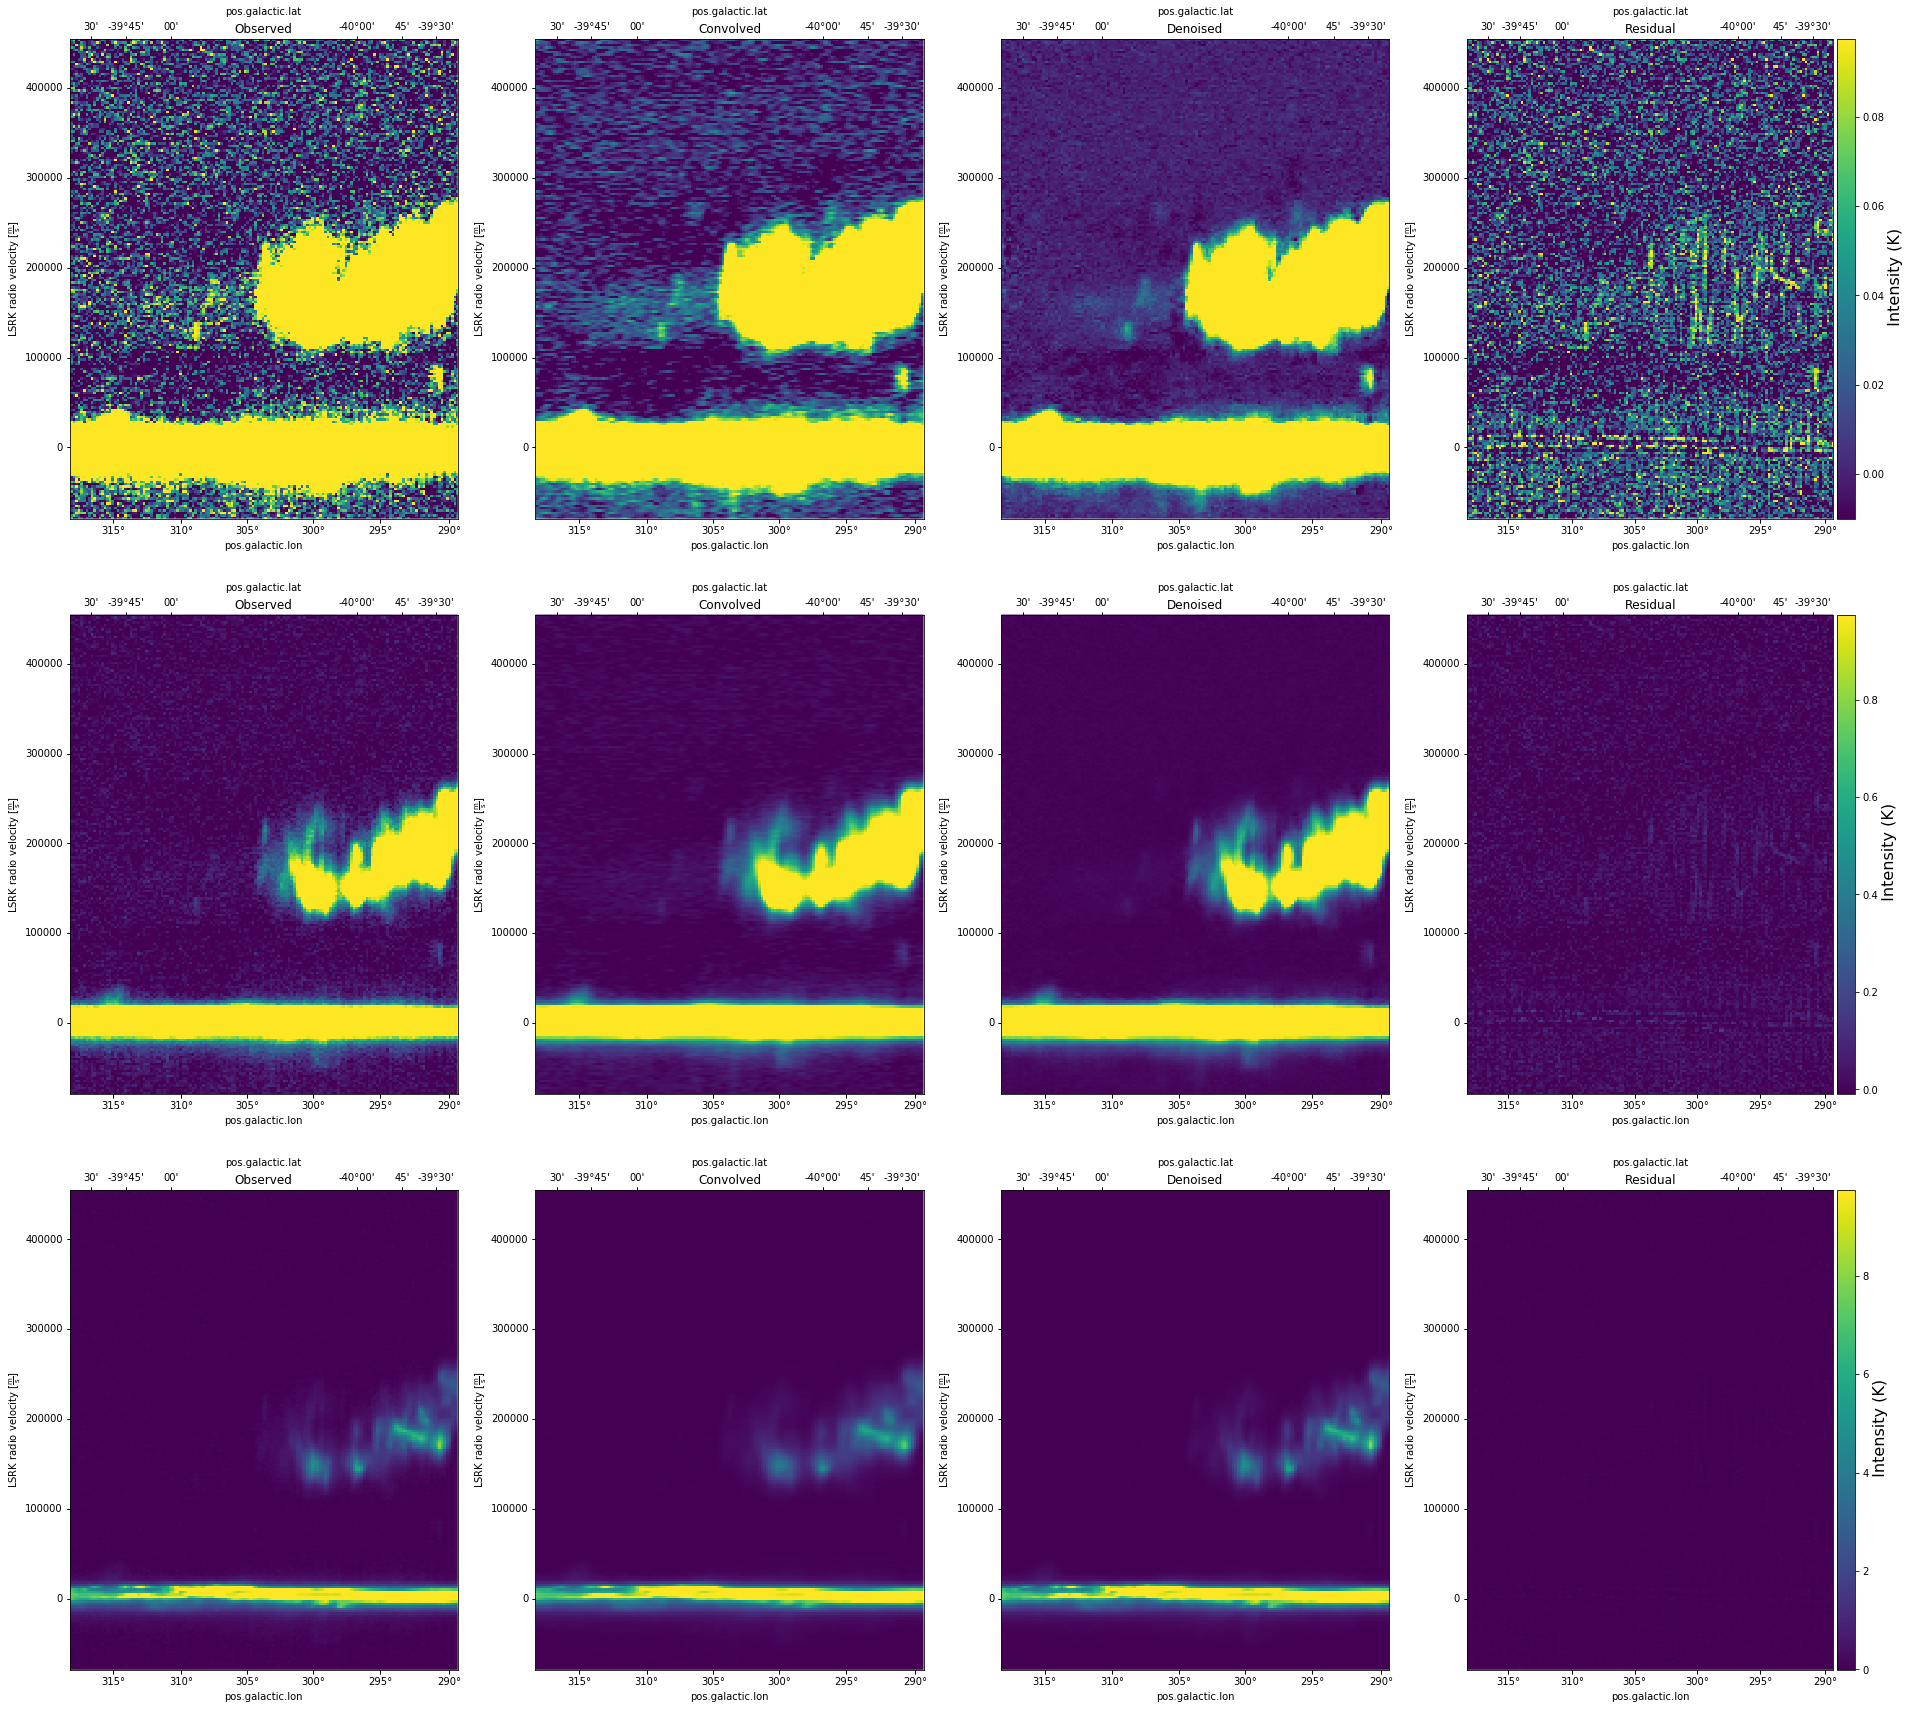

In [407]:
fig = plt.figure(figsize=(32,30))

x_blurr = gaussian_filter(x_true,sigma = (0, 1, 1))
max_val = np.max([np.max(x_blurr[:, :, :]), np.std(x_blurr[:, :, :])]) * 0.001
min_val = -1e-2
for channel in [75]:
    ax = fig.add_subplot(3, 4, 1, projection=hi4pi_wcs[195:395,channel,:])
    ax.imshow(x_true[:,channel,:], vmax=max_val,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Observed")
    ax = fig.add_subplot(3, 4, 2, projection=hi4pi_wcs[195:395, channel,:])
    ax.imshow(x_blurr[:,channel,:], vmax=max_val,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Convolved")
    ax = fig.add_subplot(3, 4, 3, projection=hi4pi_wcs[195:395, channel,:])
    ax.imshow(np.real(z[:,channel, :]), vmax=max_val,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Denoised")
    ax = fig.add_subplot(3, 4, 4, projection=hi4pi_wcs[195:395, channel,:])
    ax.set_title("Residual")
    cbar = colorbar(ax.imshow(np.real(y[:,channel, :] - z[:, channel, :]), vmax=max_val, vmin=min_val,origin='lower',aspect="auto"), fig, ax);
    cbar.set_label(''.join([''r' ', 'Intensity (', header['BUNIT'], ')']), size=16)
    ax = fig.add_subplot(3, 4, 5, projection=hi4pi_wcs[195:395,channel,:])
    ax.imshow(x_true[:,channel,:], vmax=max_val*10,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Observed")
    ax = fig.add_subplot(3, 4, 6, projection=hi4pi_wcs[195:395, channel,:])
    ax.imshow(x_blurr[:,channel,:], vmax=max_val*10,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Convolved")
    ax = fig.add_subplot(3, 4, 7, projection=hi4pi_wcs[195:395, channel,:])
    ax.imshow(np.real(z[:,channel, :]), vmax=max_val*10,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Denoised")
    ax = fig.add_subplot(3, 4, 8, projection=hi4pi_wcs[195:395, channel,:])
    ax.set_title("Residual")
    cbar = colorbar(ax.imshow(np.real(y[:,channel, :] - z[:, channel, :]), vmax=max_val*10, vmin=min_val,origin='lower',aspect="auto"), fig, ax);
    cbar.set_label(''.join([''r' ', 'Intensity (', header['BUNIT'], ')']), size=16)
    ax = fig.add_subplot(3, 4, 9, projection=hi4pi_wcs[195:395,channel,:])
    ax.imshow(x_true[:,channel,:], vmax=max_val*100,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Observed")
    ax = fig.add_subplot(3, 4, 10, projection=hi4pi_wcs[195:395, channel,:])
    ax.imshow(x_blurr[:,channel,:], vmax=max_val*100,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Convolved")
    ax = fig.add_subplot(3, 4, 11, projection=hi4pi_wcs[195:395, channel,:])
    ax.imshow(np.real(z[:,channel, :]), vmax=max_val*100,vmin=min_val,origin='lower',aspect="auto")
    ax.set_title("Denoised")
    ax = fig.add_subplot(3, 4, 12, projection=hi4pi_wcs[195:395, channel,:])
    ax.set_title("Residual")
    cbar = colorbar(ax.imshow(np.real(y[:,channel, :] - z[:, channel, :]), vmax=max_val*100, vmin=min_val,origin='lower',aspect="auto"), fig, ax);
    cbar.set_label(''.join([''r' ', 'Intensity (', header['BUNIT'], ')']), size=16)
fig.savefig("hi4pi_profile.pdf", bbox_inches = 'tight', pad_inches = 0)

We now do the same for the gradient map of the signal

In [67]:
def write_fits_h(name, data, head):
    hdu = fits.PrimaryHDU(data)
    hdu.header=head
    hdu.header['DATAMAX'] = np.max(data)
    hdu.header['DATAMIN'] = np.min(data)
    hdu.writeto(name, overwrite=True)

In [68]:
write_fits_h("denoised_hi.fits",np.real(z), header)

In [69]:
write_fits_h("true_hi.fits",x_true, header)

In [70]:
write_fits_h("res_hi.fits",x_true - np.real(z), header)

In [71]:
hi_data = fits.open("denoised_hi.fits")

In [72]:
cube = SpectralCube.read(hi_data)